## 1. Carga de datos y limpieza inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data_dir = 'results/'

In [3]:
#data = pd.read_csv(data_dir + 'GwasCat_associations.r2020-05-03.parsed.csv.gz')
data = pd.read_table(data_dir + 'gwas_cat.filtrado.tsv.gz')

In [4]:
data.head()

,fenotipo,alelo_riesgo,categoria_fenotipo,genes_reportados,genes_mapeados,contexto,OR_or_beta,gen_mapeado_elegido,EFO_URI
0,Crohn's disease,rs12722489-C,Digestive system disorder,IL2RA,IL2RA,intron,1.11,IL2RA,http://www.ebi.ac.uk/efo/EFO_0000384
1,Crohn's disease,rs151181-G,Digestive system disorder,IL27 | SH2B1 | EIF3C | LAT | CD19,CLN3 | AC138894.1,intron,1.07,CLN3,http://www.ebi.ac.uk/efo/EFO_0000384
2,Crohn's disease,rs2058660-G,Digestive system disorder,IL12RL2 | IL18R1 | IL1RL1 | IL18RAP,IL18RAP,intron,1.19,IL18RAP,http://www.ebi.ac.uk/efo/EFO_0000384
3,Crohn's disease,rs6556412-A,Digestive system disorder,IL12B,AC008691.1,intron,1.18,NaN,http://www.ebi.ac.uk/efo/EFO_0000384
4,Crohn's disease,rs2797685-A,Digestive system disorder,VAMP3,PER3 | Z98884.1,intron,1.05,PER3,http://www.ebi.ac.uk/efo/EFO_0000384


In [5]:
data.shape

(112626, 9)

Seleccionamos aquellas instancias que tienen en la columna `alelo_riesgo` un SNP.

In [6]:
mask_snps = data.alelo_riesgo.str.match("^rs[0-9]+-[ATCG\?]$")
data = data[mask_snps]
data.shape

(108556, 9)

Miramos y descartamos valores faltantes

In [7]:
data.isna().sum()

fenotipo                   0
alelo_riesgo               0
categoria_fenotipo        65
genes_reportados       42935
genes_mapeados          1727
contexto                1722
OR_or_beta                 0
gen_mapeado_elegido    46056
EFO_URI                   65
dtype: int64

No nos interesan aquellas instancias que tienen valore faltantes en la columna `OR_or_beta`

In [8]:
data.dropna(subset = ['OR_or_beta'], inplace = True)
data.shape

(108556, 9)

In [9]:
data.isna().sum()

fenotipo                   0
alelo_riesgo               0
categoria_fenotipo        65
genes_reportados       42935
genes_mapeados          1727
contexto                1722
OR_or_beta                 0
gen_mapeado_elegido    46056
EFO_URI                   65
dtype: int64

**Opcional 1**: sacamos aquellos alelos que aparezcan una sola vez. Sirve más que nada para achicar la base de datos.

In [10]:
if False:
    umbral = 1
    mask_alelos_poca_frecuencia = data.alelo_riesgo.value_counts() <=1
    mask_alelos_poca_frecuencia.head()

    alelos_poca_frecuencia = list(mask_alelos_poca_frecuencia.index[mask_alelos_poca_frecuencia.values])
    print(len(alelos_poca_frecuencia))

    mask_descartables = data.alelo_riesgo.isin(alelos_poca_frecuencia)
    mask_descartables

    print(data.shape)
    data = data[~mask_descartables]
    print(data.shape)

**Opcional 2:** Sacamos aquellos fenotipos que aparecen una sola vez:

In [11]:
if False:
    umbral = 1
    mask_fenotipos_poca_frecuencia = data.fenotipo.value_counts() <=1
    mask_fenotipos_poca_frecuencia.head()
    fenotipos_poca_frecuencia = list(mask_fenotipos_poca_frecuencia.index[mask_fenotipos_poca_frecuencia.values])
    print(len(fenotipos_poca_frecuencia))
    mask_descartables = data.fenotipo.isin(fenotipos_poca_frecuencia)
    # mask_descartables
    print(data.shape)
    data = data[~mask_descartables]
    print(data.shape)

## 2. Tripletes `alelo_riesgo`, `fenotipo` y `OR_or_beta`

In [12]:
data_tripletes = data[['alelo_riesgo', 'fenotipo', 'OR_or_beta']]
print(data_tripletes.shape)
data_tripletes.head()

(108556, 3)


,alelo_riesgo,fenotipo,OR_or_beta
0,rs12722489-C,Crohn's disease,1.11
1,rs151181-G,Crohn's disease,1.07
2,rs2058660-G,Crohn's disease,1.19
3,rs6556412-A,Crohn's disease,1.18
4,rs2797685-A,Crohn's disease,1.05


## 3. Train test split y componente gigante

Hay más de una forma de hacer una separación de datos de entrenamiento y testeo. Vamos a tomar algunos elementos de la matriz de incidencia al azar y sacarlos, asegurándonos que:
1. La red resultante tenga una única componente gigante.
2. Cada fenotipo y alelo separado en el conjunto de test siga apareciendo en el conjunto de train.

Primero chequeamos que la red así como está tenga una única componente gigante. Sino, seleccionamos la componente gigante.

In [13]:
import networkx as nx

In [14]:
red = nx.Graph()
red.add_edges_from(data_tripletes[['alelo_riesgo', 'fenotipo']].values)
print(f'Tiene una unica componente gigante: {nx.is_connected(red)}')

Tiene una unica componente gigante: False


Veamos cómo son las componentes:

In [15]:
# Devuelve conjuntos de nodos, agrupados por componente
Componentes = nx.connected_components(red)
print(f'En total hay {len(list(Componentes))} componentes en la red')

En total hay 1749 componentes en la red


In [16]:
# Armo una lista de componentes, ordenadas por tamaño
lista_redes_componentes=[red.subgraph(componente) for componente in sorted(nx.connected_components(red), key=len, reverse=True)]
n_elementos_redes_componentes=[componente.number_of_edges() for componente in lista_redes_componentes]
print(n_elementos_redes_componentes[:20])
componente_gigante = lista_redes_componentes[0]
nodos_componente_gigante = list(componente_gigante.nodes())

[94093, 481, 383, 143, 137, 97, 96, 92, 87, 81, 74, 70, 68, 68, 68, 65, 62, 56, 61, 56]


Chusmeamos cómo son las redes que no están en la componente gigante:

In [17]:
if True:
    print(lista_redes_componentes[-1500].nodes())

['rs6414928-A', 'rs2390357-G', 'rs75870422-C', 'rs80107998-T', 'rs116711337-C', 'rs4291556-C', 'rs36106334-G', 'rs6123683-G', 'rs4744531-A', 'rs141606281-T', 'rs7117543-C', 'rs1404872-A', 'rs12565500-A', 'rs17133277-G', 'Facial morphology (factor 5, width of mouth relative to central midface)', 'rs112079675-C']


Descartamos de `data_tripletes` los enlaces que no estén en la componente gigante.

In [18]:
mask_componente_gigante = data_tripletes.fenotipo.isin(nodos_componente_gigante)
print(data_tripletes.shape)
data_tripletes = data_tripletes[mask_componente_gigante]
print(data_tripletes.shape)

(108556, 3)
(94093, 3)


In [19]:
data_tripletes.reset_index(inplace = True, drop = True)
data_tripletes.head()

,alelo_riesgo,fenotipo,OR_or_beta
0,rs12722489-C,Crohn's disease,1.11
1,rs151181-G,Crohn's disease,1.07
2,rs2058660-G,Crohn's disease,1.19
3,rs6556412-A,Crohn's disease,1.18
4,rs2797685-A,Crohn's disease,1.05


In [20]:
n_alelos = data_tripletes.alelo_riesgo.nunique()
n_fenotipos = data_tripletes.fenotipo.nunique()
print(f'Hay {n_alelos} alelo unicos y {n_fenotipos} fenotipos unicos')

Hay 75848 alelo unicos y 1588 fenotipos unicos


#### Train/Test split

Vamos a seleccionar `n_test` filas al azar de `data_tripletes` y ver si se cumple lo que pedimos más arriba.

Sacar al azar sin tener en cuenta el grado de cada nodo no funcionó, por lo que debemos hacerlo de forma más ordenada.

Primero seleccionamos aquellos alelos que aparezcan más de `umbral_alelo` veces.

In [21]:
umbral_alelo = 4
mask_alelos = data_tripletes.alelo_riesgo.value_counts() >= umbral_alelo
alelos_a_considerar = list((data_tripletes.alelo_riesgo.value_counts()[mask_alelos]).index)
print(len(alelos_a_considerar))

1474


In [22]:
umbral_fenotipo = 4
mask_fenotipos = data_tripletes.fenotipo.value_counts() >= umbral_fenotipo
fenotipos_a_considerar = list((data_tripletes.fenotipo.value_counts()[mask_fenotipos]).index)
print(len(fenotipos_a_considerar))

1307


In [23]:
n_test = 500

mask_alelos_y_fenotipos = np.logical_and(data_tripletes.alelo_riesgo.isin(alelos_a_considerar), data_tripletes.fenotipo.isin(fenotipos_a_considerar))
indices_a_considerar = list(data_tripletes[mask_alelos_y_fenotipos].index)
todos_indices = list(data_tripletes.index)
for i in range(0,10):
    np.random.seed(i)
    idx_test = np.random.choice(indices_a_considerar, size = n_test, replace = False)
    data_tripletes_test = data_tripletes.iloc[idx_test, :]
    idx_train = list(set(todos_indices) - set(idx_test))
    data_tripletes_train = data_tripletes.iloc[idx_train, :]
    if data_tripletes_train.alelo_riesgo.nunique() == n_alelos:
        if data_tripletes_train.fenotipo.nunique() == n_fenotipos:
            red_train = nx.Graph()
            red_train.add_edges_from(data_tripletes_train[['alelo_riesgo', 'fenotipo']].values)
            lista_redes_componentes_train=[red_train.subgraph(componente) for componente in sorted(nx.connected_components(red_train), key=len, reverse=True)]
            print(len(lista_redes_componentes_train))
            if len(lista_redes_componentes_train) == 1:
                print(f'Exito: {i}')
                break

3
6
10
5
10
3
1
Exito: 6


In [24]:
print(data_tripletes_train.alelo_riesgo.nunique())
print(data_tripletes_train.fenotipo.nunique())

75848
1588


In [25]:
print(data_tripletes_test.alelo_riesgo.nunique())
print(data_tripletes_test.fenotipo.nunique())

429
225


#### Otra Separación 1 - Alelos "nuevos"

Tomamos alelos al azar y los sacamos de la matriz de utilidad. De esta forma, no aportarán a las similitudes de los fenotipos.

Vamos a sacar alelos que tengan al menos grado 3 y como máximo grado 5 

In [26]:
if False:
    np.random.seed(42)
    n_alelos_a_sacar = 100
    alelos_a_sacar = []

    lista_alelos_desordenada = list(dict_id_to_alelo.keys())
    lista_alelos_desordenada = np.random.choice(lista_alelos_desordenada,len(lista_alelos_desordenada), replace = False)

    grados = data_bipartita.sum(axis = 1)
    for alelo in lista_alelos_desordenada:
    #     pass
        grado = grados.iloc[alelo]

        if grado >=3 and grado <=5:
            alelos_a_sacar.append(alelo)

        if len(alelos_a_sacar) == n_alelos_a_sacar:
            break

    data_bipartita_test_1 = data_bipartita.iloc[alelos_a_sacar,:]
    print(data_bipartita_test_1.shape)
    print(data_bipartita_test_1.sum().sum())

    data_bipartita_train = data_bipartita.drop(alelos_a_sacar)
    print(data_bipartita_train.shape)

    #### ESTO SE PUEDE MEJORAR, PERO POR AHORA CHEQUEAMOS QUE NO QUEDE UN FENOTIPO DE GRADO 1
#     Nuevamente, lo mejor sería que el conjunto de train tenga una única componente.

    data_bipartita_train.sum().min()

#     Sacamos del conjunto de test algunos fenotipos conocidos, hasta que quede un solo fenotipo conocido. ¿ESTUDIAR EN FUNCION DE ESTE HIPERPARÁMETRO?

    np.random.seed(42)
    n_fenotipos_a_dejar = 1

    for idx, row in data_bipartita_test_1.iterrows():

        fenotipos_asociados = list(row[row == 1].index)
        fenotipos_asociados = np.random.choice(fenotipos_asociados, len(fenotipos_asociados), replace = False)
        contador = 0
        for fenotipo in fenotipos_asociados:
            data_bipartita_test_1.loc[idx, fenotipo] = 0
            contador +=1
            if contador == len(fenotipos_asociados) - n_fenotipos_a_dejar:
                break
                
    data_bipartita_test_1.sum().sum()

## 4. Matriz de Incidencia


MEJORAR PARA QUE EN EL INDICE APAREZCA EL ALELO Y SCARASE DE ENCIMA EL DICCIONARIO

In [27]:
def crear_matriz_de_incidencia(data_tripletes):
    alelos = data_tripletes.alelo_riesgo.unique()
    fenotipos = data_tripletes.fenotipo.unique()
    n_alelos = data_tripletes.alelo_riesgo.nunique()
    n_fenotipos = data_tripletes.fenotipo.nunique()
    
    matriz_incidencia = pd.DataFrame(np.zeros((n_alelos, n_fenotipos)), columns = fenotipos, index = alelos, dtype = np.int8)
    
    for _, row in data_tripletes.iterrows():
        alelo_row = row.alelo_riesgo
        fenotipo_row = row.fenotipo
#         id_alelo = dict_alelo_to_id[alelo_row]
        matriz_incidencia.loc[alelo_row, fenotipo_row] = 1
        
    return matriz_incidencia

In [28]:
matriz_incidencia_train = crear_matriz_de_incidencia(data_tripletes_train)
matriz_incidencia_train.head()

,Crohn's disease,Obesity (early onset extreme),Soluble levels of adhesion molecules,Multiple sclerosis,Alcohol consumption (transferrin glycosylation),Colorectal cancer,Ulcerative colitis,Psoriasis,Nicotine dependence,Pulmonary function,...,Lumbar spine bone mineral density (integral),Lumbar spine bone mineral density (trabecular),Age of smoking initiation (MTAG),Cigarettes smoked per day (MTAG),Cognitive performance,Self-reported math ability (MTAG),Highest math class taken,Highest math class taken (MTAG),Cognitive performance (MTAG),Self-reported math ability
rs12722489-C,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs151181-G,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs2058660-G,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs6556412-A,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs2797685-A,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Chequeos**

La suma de todos los elementos de `matriz_incidencia` debe dar la cantidad de filas en `data_tripletes`

In [29]:
matriz_incidencia_train.sum().sum() == data_tripletes_train.shape[0]

True

La suma por columnas del `value_counts()` de `data_tripletes.fenotipo`

In [30]:
(data_tripletes_train.fenotipo.value_counts().values == matriz_incidencia_train.sum().sort_values(ascending = False).values).all()

True

La suma por filas el `value_counts()` de `data_tripletes.alelo_riesgo`

In [31]:
(data_tripletes_train.alelo_riesgo.value_counts().values == matriz_incidencia_train.sum(axis = 1).sort_values(ascending = False).values).all()

True

**Distribución de grado para fenotipos**

(array([208., 170., 301., 327., 260., 142., 113.,  39.,  19.,   9.]),
 array([0.        , 0.79094895, 1.5818979 , 2.37284685, 3.1637958 ,
        3.95474475, 4.7456937 , 5.53664264, 6.32759159, 7.11854054,
        7.90948949]),
 <a list of 10 Patch objects>)

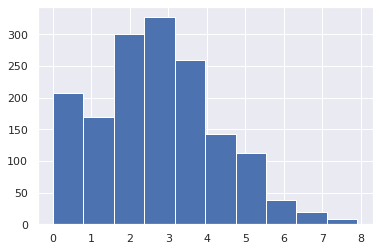

In [32]:
plt.hist(np.log(matriz_incidencia_train.sum()))

**Distribución de grado para alelos**

(array([7.5199e+04, 5.2600e+02, 6.8000e+01, 4.1000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  4.3,  7.6, 10.9, 14.2, 17.5, 20.8, 24.1, 27.4, 30.7, 34. ]),
 <a list of 10 Patch objects>)

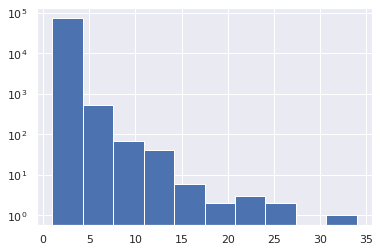

In [33]:
plt.hist(matriz_incidencia_train.sum(axis = 1), log=True)

¿VALE LA PENA ESTUDIAR ESTAS DISTRIBUCIONES?

### 4. Filtro Colaborativo Implícito

https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

En primer lugar, normalizamos con respecto a la cantidad de enlaces que tiene cada alelo. En las películas, esto se justifica como 

> *This is the idea of normalizing the user vectors so that a user with many ratings contributes less to any individual rating. This is to say that a like from a user who has only liked 10 items is more valuable to us than a like from someone who likes everything she comes across.*

In [35]:
#------------------------
# ITEM-ITEM CALCULATIONS
#------------------------

# As a first step we normalize the user vectors to unit vectors.

# magnitude = sqrt(x2 + y2 + z2 + ...)
magnitude = np.sqrt(np.square(matriz_incidencia_train).sum(axis=1))

# # unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
data_bipartita_normalizada = matriz_incidencia_train.divide(magnitude, axis='index')
data_bipartita_normalizada

,Crohn's disease,Obesity (early onset extreme),Soluble levels of adhesion molecules,Multiple sclerosis,Alcohol consumption (transferrin glycosylation),Colorectal cancer,Ulcerative colitis,Psoriasis,Nicotine dependence,Pulmonary function,...,Lumbar spine bone mineral density (integral),Lumbar spine bone mineral density (trabecular),Age of smoking initiation (MTAG),Cigarettes smoked per day (MTAG),Cognitive performance,Self-reported math ability (MTAG),Highest math class taken,Highest math class taken (MTAG),Cognitive performance (MTAG),Self-reported math ability
rs12722489-C,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rs151181-G,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rs2058660-G,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rs6556412-A,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rs2797685-A,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs943262-C,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
rs880082-A,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
rs902627-A,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
rs31489-C,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Luego,calculamos la similaridad coseno para cada columna, obteniendo así qué fenotipos son parecidos.

In [36]:
def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

# Build the similarity matrix
data_matrix = calculate_similarity(data_bipartita_normalizada)
data_matrix.head()

,Crohn's disease,Obesity (early onset extreme),Soluble levels of adhesion molecules,Multiple sclerosis,Alcohol consumption (transferrin glycosylation),Colorectal cancer,Ulcerative colitis,Psoriasis,Nicotine dependence,Pulmonary function,...,Lumbar spine bone mineral density (integral),Lumbar spine bone mineral density (trabecular),Age of smoking initiation (MTAG),Cigarettes smoked per day (MTAG),Cognitive performance,Self-reported math ability (MTAG),Highest math class taken,Highest math class taken (MTAG),Cognitive performance (MTAG),Self-reported math ability
Crohn's disease,1.00000,0.0,0.0,0.00727,0.0,0.0,0.128794,0.001929,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Obesity (early onset extreme),0.00000,1.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Soluble levels of adhesion molecules,0.00000,0.0,1.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Multiple sclerosis,0.00727,0.0,0.0,1.00000,0.0,0.0,0.001775,0.001868,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alcohol consumption (transferrin glycosylation),0.00000,0.0,0.0,0.00000,1.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Veamos similaridades

In [37]:
# print(data_matrix.loc['Drinking behavior'].nlargest(25))
print(data_matrix.loc['Educational attainment (MTAG)'].nlargest(30))

Educational attainment (MTAG)                                                      1.000000
Educational attainment (years of education)                                        0.283334
Highest math class taken (MTAG)                                                    0.146236
Cognitive performance (MTAG)                                                       0.061917
Attention deficit hyperactivity disorder or caudate nucleus volume (pleiotropy)    0.020097
Self-reported math ability (MTAG)                                                  0.019937
Intelligence (MTAG)                                                                0.011527
Household income (MTAG)                                                            0.010223
Intelligence                                                                       0.007085
Cognitive performance                                                              0.006591
Highest math class taken                                                        

Construimos una nueva matriz, con los `n_neighbours` de cada fenotipo. Vendrían a ser los `n_neighbours` fenotipos más cercanos a cada fenotipos.

In [38]:
n_neighbours = 20
data_neighbours = pd.DataFrame(index=data_matrix.columns, columns=range(1,n_neighbours+1))
for i in range(0, len(data_matrix.columns)):
    data_neighbours.iloc[i,:n_neighbours] = data_matrix.iloc[0:,i].sort_values(ascending=False)[:n_neighbours].index
data_neighbours.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Crohn's disease,Crohn's disease,Inflammatory bowel disease,Ulcerative colitis,Gut microbiota (functional units),Multiple sclerosis,Sarcoidosis,Sjögren's syndrome,Ankylosing spondylitis,Allergic rhinitis,Eosinophilic esophagitis,Atopic dermatitis,Stearic acid (18:0) levels,Disease progression in age-related macular deg...,Monokine induced by gamma interferon levels,Phosphatidylcholine levels,Palmitoleic acid (16:1n-7) levels,Liver enzyme levels (gamma-glutamyl transferase),Keratinocyte cancer (MTAG),Plasma omega-6 polyunsaturated fatty acid leve...,Hay fever and/or eczema
Obesity (early onset extreme),Obesity (early onset extreme),Height adjusted BMI,Age at adiposity rebound,Obesity,Childhood body mass index,Glycated hemoglobin levels,Body mass index,Medication use (HMG CoA reductase inhibitors),Hip circumference,Weight,Hand grip strength,Morning person,Chronotype,C-reactive protein levels,Contrast sensitivity,Symmetrical dimethylarginine levels,B-type natriuretic peptide levels,Alcohol consumption (max-drinks),L-arginine levels,Asymmetrical dimethylarginine levels
Soluble levels of adhesion molecules,Soluble levels of adhesion molecules,Blood metabolite ratios,Liver enzyme levels (alkaline phosphatase),Red blood cell traits,Blood protein levels,Red blood cell count,Asymmetrical dimethylarginine levels,Alzheimer's disease (age of onset),Acne (severe),Urinary uromodulin levels,Bipolar disorder with mood-incongruent psychosis,B-type natriuretic peptide levels,Contrast sensitivity,Response to alcohol consumption (flushing resp...,Alcohol consumption (max-drinks),L-arginine levels,Red blood cell fatty acid levels,Symmetrical dimethylarginine levels,Glucose homeostasis traits,Birth length
Multiple sclerosis,Multiple sclerosis,Systolic blood pressure response to thiazide a...,Heavy menstrual bleeding,Primary biliary cirrhosis,Crohn's disease,Inflammatory bowel disease,Primary central nervous system lymphoma,Rheumatoid arthritis (ACPA-positive),Alopecia areata,Uterine fibroids and heavy menstrual bleeding,Primary sclerosing cholangitis,Systemic lupus erythematosus,Autoimmune thyroid diseases (Graves disease or...,Follicular lymphoma,Medication use (thyroid preparations),Renal cell carcinoma,Glioblastoma,Plasma free amino acid levels,Multiple myeloma,Plasma free amino acid levels (adjusted for tw...
Alcohol consumption (transferrin glycosylation),Alcohol consumption (transferrin glycosylation),Iron status biomarkers (transferrin levels),Hematological parameters,Hematology traits,Iron status biomarkers (ferritin levels),Cardiovascular disease risk factors,Iron status biomarkers (iron levels),Iron status biomarkers (transferrin saturation),Hematocrit,Red blood cell count,Mean corpuscular hemoglobin,Diastolic blood pressure,Osteoarthritis (hip),Conscientiousness,Response to alcohol consumption (flushing resp...,Alcohol consumption (max-drinks),L-arginine levels,Asymmetrical dimethylarginine levels,Symmetrical dimethylarginine levels,Glucose homeostasis traits


Elegimos un alelo dentro del conjunto de entrenamiento

In [39]:
# np.random.seed(43)
alelo_prueba = np.random.choice(data_tripletes_train.alelo_riesgo.unique())
# alelo_prueba = 'rs6739779-C'
# alelo_prueba = 'rs4549631-C'
print(f'Alelo de prueba: {alelo_prueba}')


known_alelo_fenotipos = data_bipartita_normalizada.loc[alelo_prueba,:]
known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
print(f'Fenotipos asociados al alelo: {known_alelo_fenotipos}')

Alelo de prueba: rs61753147-A
Fenotipos asociados al alelo: ['Atypical femoral fracture in phosphonate treatment']


Dado esos fenotipos, seleccionamos los similares a partir de `data_neighbours`

In [40]:
# Construct the neighbourhood from the most similar items to the
# ones our alelo it's related
most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]
# most_similar_fenotipos
similar_list = most_similar_fenotipos.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
print(f'Fenotipos similares, sin rankear: {similar_list}')

Fenotipos similares, sin rankear: ['Atypical femoral fracture in phosphonate treatment', "Alzheimer's disease (age of onset)", 'L-arginine levels', 'Alcohol consumption (max-drinks)', 'Bipolar disorder', 'Asymmetrical dimethylarginine levels', 'Bisphosphonate-associated atypical femoral fracture', 'B-type natriuretic peptide levels', 'Bipolar disorder with mood-incongruent psychosis', 'Birth length', 'Symmetrical dimethylarginine levels', 'Glucose homeostasis traits', 'Esophageal squamous cell carcinoma', 'Contrast sensitivity', 'Red blood cell fatty acid levels', 'Response to alcohol consumption (flushing response)', 'Urinary uromodulin levels', 'Self-reported math ability', 'Lung function (forced expiratory volume in 1 second)', 'Acne (severe)']


Seleccionamos, dentro de la matriz de similaridades, los valores para los fenotipos similares

In [41]:
neighbourhood = data_matrix[similar_list].loc[similar_list]
neighbourhood.shape

(20, 20)

Creamos un vector que tiene los fenotipos similares, incluyendo los conocidos, y su *rating* (1 o 0).

In [42]:
# A user vector containing only the neighbourhood items and
# the known user likes.
fenotipos_probables = data_bipartita_normalizada.loc[alelo_prueba,:].loc[similar_list]
fenotipos_probables

Atypical femoral fracture in phosphonate treatment      1.0
Alzheimer's disease (age of onset)                      0.0
L-arginine levels                                       0.0
Alcohol consumption (max-drinks)                        0.0
Bipolar disorder                                        0.0
Asymmetrical dimethylarginine levels                    0.0
Bisphosphonate-associated atypical femoral fracture     0.0
B-type natriuretic peptide levels                       0.0
Bipolar disorder with mood-incongruent psychosis        0.0
Birth length                                            0.0
Symmetrical dimethylarginine levels                     0.0
Glucose homeostasis traits                              0.0
Esophageal squamous cell carcinoma                      0.0
Contrast sensitivity                                    0.0
Red blood cell fatty acid levels                        0.0
Response to alcohol consumption (flushing response)     0.0
Urinary uromodulin levels               

Calculamos los scores y ordenamos.

In [43]:
# Calculate the score.
score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
# score
score.sort_values(ascending = False, inplace = True)
# score

E imprimimos los fenotipos conocidos y el ranking

In [44]:
print(known_alelo_fenotipos)
print(score)

['Atypical femoral fracture in phosphonate treatment']
Atypical femoral fracture in phosphonate treatment      0.968438
Bisphosphonate-associated atypical femoral fracture     0.023399
Bipolar disorder                                        0.008491
Lung function (forced expiratory volume in 1 second)    0.000000
Alzheimer's disease (age of onset)                      0.000000
L-arginine levels                                       0.000000
Alcohol consumption (max-drinks)                        0.000000
Asymmetrical dimethylarginine levels                    0.000000
B-type natriuretic peptide levels                       0.000000
Bipolar disorder with mood-incongruent psychosis        0.000000
Acne (severe)                                           0.000000
Symmetrical dimethylarginine levels                     0.000000
Glucose homeostasis traits                              0.000000
Esophageal squamous cell carcinoma                      0.000000
Contrast sensitivity               

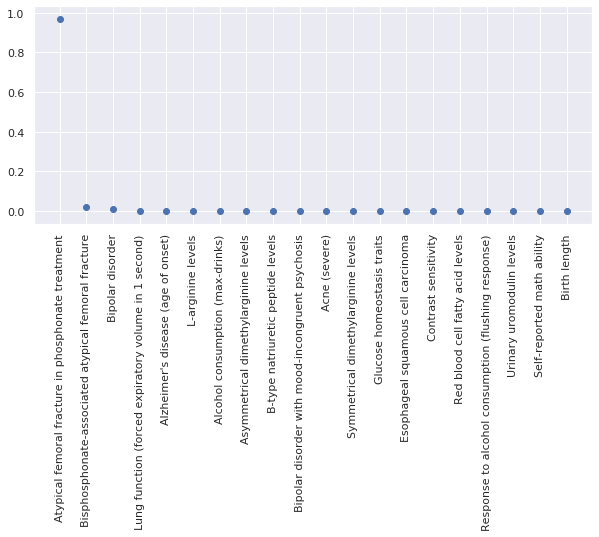

In [45]:
# sns.barplot(score.index, score.values)
plt.figure(figsize = (10,4))
plt.scatter(score.index, score.values)
plt.xticks(rotation = 90)
plt.show()

In [46]:
def recomendaciones_alelo(alelo_index, data_bipartita_normalizada, data_neighbours, data_matrix):
    known_alelo_fenotipos = data_bipartita_normalizada.iloc[alelo_index]
    known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values

    most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]

    similar_list = most_similar_fenotipos.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))

    neighbourhood = data_matrix[similar_list].loc[similar_list]

    fenotipos_probables = data_bipartita_normalizada.iloc[alelo_prueba_index].loc[similar_list]

    score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
    score.sort_values(ascending = False, inplace = True)

    return score

In [47]:
score = recomendaciones_alelo(alelo_prueba_index, data_bipartita_normalizada, data_neighbours, data_matrix)

NameError: name 'alelo_prueba_index' is not defined

In [ ]:
plt.scatter(score.index, score.values)
plt.xticks(rotation = 90)

### Sobre Conjunto de Test

"A mano" por ahora

In [48]:
# np.random.seed(50)
alelo_prueba = np.random.choice(data_tripletes_test.alelo_riesgo)
print(f'Alelo a probar: {alelo_prueba}')

todos_fenotipos_asociados = data_tripletes[data_tripletes.alelo_riesgo == alelo_prueba].fenotipo.values
fenotipos_en_test = data_tripletes_test[data_tripletes_test.alelo_riesgo == alelo_prueba].fenotipo.values
# known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
print(f'Todos fenotipos asociados al alelo: {todos_fenotipos_asociados}')
print(f'Fenotipos en Test: {fenotipos_en_test}')

fenotipos_en_train = data_bipartita_normalizada.loc[alelo_prueba]
fenotipos_en_train = fenotipos_en_train[fenotipos_en_train >0].index.values
print(f'Fenotipos en Train: {fenotipos_en_train}')

Alelo a probar: rs1535-A
Todos fenotipos asociados al alelo: ['Plasma omega-3 polyunsaturated fatty acid levels (alphalinolenic acid)'
 'Plasma omega-3 polyunsaturated fatty acid levels (docosapentaenoic acid)'
 'Trans fatty acid levels' 'Total cholesterol levels'
 'HDL cholesterol levels' 'Triglyceride levels' 'Colorectal cancer']
Fenotipos en Test: ['Plasma omega-3 polyunsaturated fatty acid levels (docosapentaenoic acid)']
Fenotipos en Train: ['Colorectal cancer' 'HDL cholesterol levels'
 'Plasma omega-3 polyunsaturated fatty acid levels (alphalinolenic acid)'
 'Triglyceride levels' 'Trans fatty acid levels'
 'Total cholesterol levels']


In [49]:
most_similar_fenotipos = data_neighbours.loc[fenotipos_en_test]
similar_list = most_similar_fenotipos.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
neighbourhood = data_matrix[similar_list].loc[similar_list]

In [50]:
fenotipos_probables = data_bipartita_normalizada.loc[alelo_prueba].loc[similar_list]
# fenotipos_probables

In [51]:
score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
score.sort_values(ascending = False, inplace = True)
print(f'Fenotipos en Train: {fenotipos_en_train}')
print(f'Fenotipos en Test: {fenotipos_en_test}')
print(score.nlargest(50))

Fenotipos en Train: ['Colorectal cancer' 'HDL cholesterol levels'
 'Plasma omega-3 polyunsaturated fatty acid levels (alphalinolenic acid)'
 'Triglyceride levels' 'Trans fatty acid levels'
 'Total cholesterol levels']
Fenotipos en Test: ['Plasma omega-3 polyunsaturated fatty acid levels (docosapentaenoic acid)']
Trans fatty acid levels                                                     0.378260
Plasma omega-3 polyunsaturated fatty acid levels (alphalinolenic acid)      0.347374
Plasma omega-3 polyunsaturated fatty acid levels (docosapentaenoic acid)    0.035953
Plasma omega-3 polyunsaturated fatty acid level (eicosapentaenoic acid)     0.025426
Plasma omega-6 polyunsaturated fatty acid levels (gamma-linolenic acid)     0.008249
Palmitoleic acid (16:1n-7) levels                                           0.007986
Irritable mood                                                              0.003867
Nasal polyps                                                                0.002253
Inflam

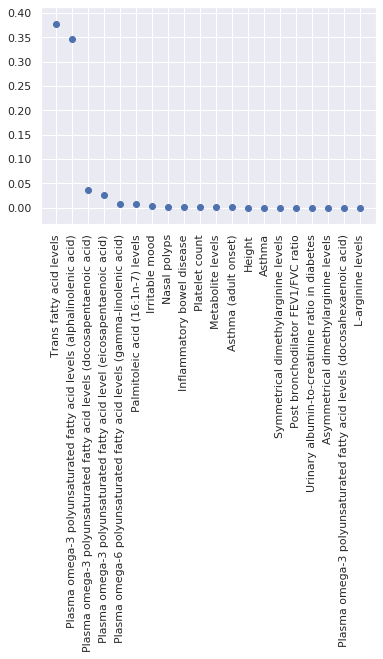

In [52]:
plt.scatter(score.index, score.values)
plt.xticks(rotation = 90)
plt.show()

1. grafico de fenotipos vs score
1. capacidad de priorizar dado 
1. Usar el paper de zhou


MARTES - 5 min
dimensión de los datos
encuadrar el problema biológico o metodológico



In [53]:
def indices_aciertos(fenotipos_recomendados, fenotipos_a_evaluar):
    indices = []
    for fenotipo in fenotipos_a_evaluar:
        if fenotipo in fenotipos_recomendados:
            indices.append(fenotipos_recomendados.index(fenotipo))
        else:
            indices.append(-1)
    return indices

In [57]:
n = 100
fenotipos_recomendados = list(score.index)
# fenotipos_recomendados = [x for x in fenotipos_recomendados if x not in fenotipos_train]



indices_aciertos(fenotipos_recomendados, todos_fenotipos_asociados)

[1, 2, 0, -1, -1, -1, -1]

In [ ]:
n = 10

resultados = []

for alelo_prueba_index in data_bipartita_test_1.index:
#     print(alelo_prueba_index)
    alelo_prueba = dict_id_to_alelo[alelo_prueba_index]
    known_alelo_fenotipos = data_bipartita_test_1.loc[alelo_prueba_index]
    known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
#     print(f'Fenotipos asociados al alelo para generar recomendaciones: {known_alelo_fenotipos}')
    
    fenotipos_reportados_alelo = data_bipartita.loc[alelo_prueba_index]
    fenotipos_reportados_alelo = fenotipos_reportados_alelo[fenotipos_reportados_alelo >0].index.values
#     print(f'Todos fenotipos asociados al alelo: {fenotipos_reportados_alelo}')
    
    most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]
    similar_list = most_similar_fenotipos.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))
    neighbourhood = data_matrix[similar_list].loc[similar_list]
    
    fenotipos_probables = data_bipartita_test_1.loc[alelo_prueba_index].loc[similar_list]
    score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
    score.sort_values(ascending = False, inplace = True)
#     print(score.nlargest(5))

    
    fenotipos_recomendados = list(score.index)
    fenotipos_usados_para_recomendar = known_alelo_fenotipos
    fenotipos_conocidos = fenotipos_reportados_alelo
    
    n_0 = len(fenotipos_usados_para_recomendar)
    fenotipos_recomendados = fenotipos_recomendados[n_0:n_0+n]
    fenotipos_a_evaluar = [x for x in fenotipos_conocidos if x not in fenotipos_usados_para_recomendar]
    
    idxs = indices_aciertos(fenotipos_recomendados, fenotipos_a_evaluar)
    
    resultados_alelo = dict(zip(fenotipos_a_evaluar, idxs))
    resultados_alelo['alelo'] = alelo_prueba
    resultados_alelo['indice_alelo'] = alelo_prueba_index
    resultados.append(resultados_alelo)
    
#     print(idxs)


In [ ]:
resultados_df = pd.DataFrame(resultados).set_index('indice_alelo')
resultados_df.head()

In [ ]:
indices = resultados_df.drop(columns = 'alelo').values
indices = indices[~np.isnan(indices)]
plt.hist(indices, bins = np.arange(-1.5,9.5))

In [ ]:
print(f'Porcentaje aciertos: {(indices>-1).sum()/indices.size}')
print(f'Porcentaje no aciertos: {(indices==-1).sum()/indices.size}')

### Cosas para hacer

1. Chequear sobre `categoria_fenotipo` que no sea trivial
1. Agregar segunda forma de evaluación: borrando '1' de la matriz de train
1. Chequear que al separar train y test no se rompa la red
1. Metodizar la evaluación para obtener una métrica
1. Chequear que no estemos cayendo en la parte "fácil" de la red --> ¿pregunta biológica?